In [16]:
# import libraries
import cv2
import os
import time
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt
import math

In [17]:
# set directory paths
cur_dir = os.getcwd()
parent_dir = os.path.dirname(cur_dir)
image_path = cur_dir + "/images/test"
print("current dir: ", cur_dir)
print("parent dir: ", parent_dir)
print("image path: ", image_path) 

current dir:  /Users/zach/Desktop/SDP/SmokingDartsv3
parent dir:  /Users/zach/Desktop/SDP
image path:  /Users/zach/Desktop/SDP/SmokingDartsv3/images/test


Image Resolution: 1080 x 1920


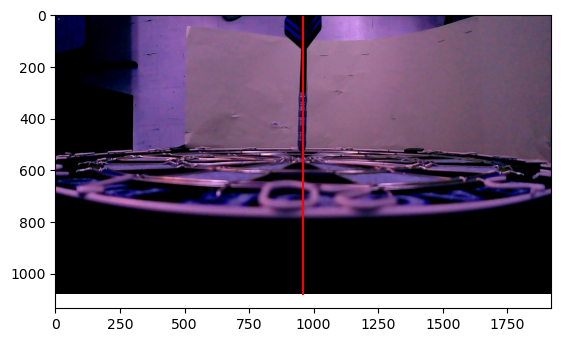

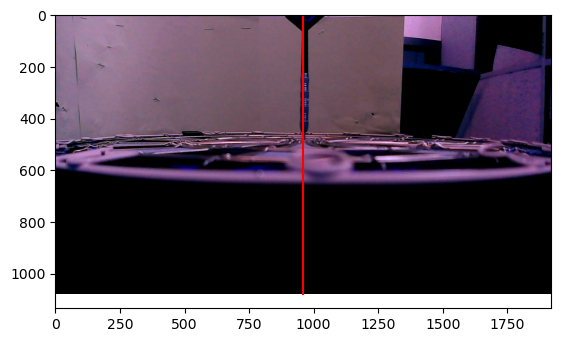

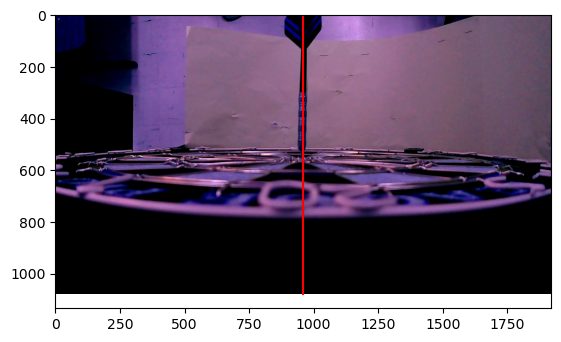

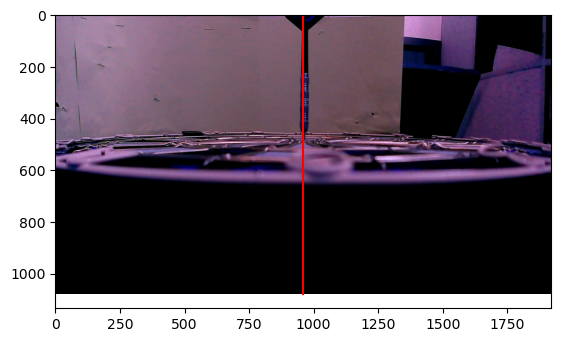

In [18]:
# load all four images from the image_path
def load_images():
    image_nodartX = cv2.imread(os.path.join(image_path, 'image_nodartX.jpeg'))
    image_nodartY = cv2.imread(os.path.join(image_path, 'image_nodartY.jpeg'))
    image_dartX = cv2.imread(os.path.join(image_path, 'image_dartX.jpeg'))
    image_dartY = cv2.imread(os.path.join(image_path, 'image_dartY.jpeg'))
    image_height, image_width, channels = image_nodartX.shape
    print('Image Resolution: {} x {}'.format(image_height, image_width))
    return image_nodartX, image_nodartY, image_dartX, image_dartY


image_nodartX, image_nodartY, image_dartX, image_dartY = load_images()
image_height, image_width, channels = image_nodartX.shape

def display_image(img):
    plt.imshow(img)
    plt.plot([int(image_width/2), int(image_width/2)], [0, image_height], 'r-')
    plt.show()
    return

display_image(image_nodartX)
display_image(image_nodartY)
display_image(image_dartX)
display_image(image_dartY)

In [26]:
fov = 110 # degrees

# compute angles from camera to dart
def compute_angles(coordinates):
    angle = [0, 0]
    angle[0] = coordinates[0] / image_width * fov
    angle[1] = coordinates[1] / image_width * fov
    return angle


# return both x and y coordinates of dart from image
def get_image_coordinates():
    # create diff images, canny images, and coordinates of dart
    x_coordinate = get_image_coordinate(image_dartX, image_nodartX)
    print("x-pixel_cor: " + str(x_coordinate))
    y_coordinate = get_image_coordinate(image_dartY, image_nodartY)
    print("x-pixel_cor: " + str(y_coordinate))
    coordinates = [x_coordinate, y_coordinate]
    return coordinates



# create difference image, perform canny edge detection, and return coordinate of dart
def get_image_coordinate(imageA, imageB):
    start_time = time.time()
    
    # create difference image
    grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    #diff = cv2.subtract(grayA, grayB)
    diff = (diff * 255).astype("uint8")

    # remove noise with erosion and dilation
    #thresh = cv2.threshold(diff, 180, 255, cv2.THRESH_OTSU)[1]
    #thresh = cv2.threshold(diff, 150, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #thresh = cv2.adaptiveThreshold(diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 147, 67)
    
    thresh = cv2.threshold(diff, 200, 255, cv2.THRESH_OTSU)[1]
    
    kernel = np.ones((11, 11), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel, iterations=1)
    
    #thresh[:40] = 255
    
    # perform canny edge detection
    edge = cv2.Canny(thresh, 250, 300)
    ctrs, hier = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # display images
    plt.imshow(diff, cmap='gray')
    plt.show()
    plt.imshow(thresh, cmap='gray')
    plt.show()
    plt.imshow(edge, cmap='gray')
    plt.show()
    
    # find coordinates of dart tip in canny edge image
    ctr = max(ctrs, key = len)
    ctr_ind = (np.argmax([xy[0][1] for xy in ctr]))

    print("Image processing time: " + str(time.time()-start_time))
    return (ctr[ctr_ind])[0][0]


# Determine Score of throw
def get_score(x_dart, y_dart):
    radius = math.sqrt((x_dart**2)+(y_dart**2)) # find the radius

    # solve for the angle
    theta = math.atan(y_dart/x_dart) # in radians
    angle = theta * (180/3.1415) # convert to degrees

    # makes sure that the arctan angle is accurate for scoring
    if x_dart < 0:
        angle = 180 + angle
    print("angle: " + str(angle))

    slice_map = [6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10]
    slice_key = int(((angle + 9)%360)//18)
    slice_area = slice_map[slice_key]

    print("score area: " + str(slice_area))
    print("Radius: " + str(radius))
    score = 0
    channel = 0
    if radius <= 5:
        score = 50
        print("Bullseye!!!")
    elif radius > 5 and radius <= 15:
        score = 25
        print("Bull!!!")
    elif radius > 15 and radius < 95:
        channel = 12
        score = slice_area
    elif radius >= 95 and radius <= 105:
        score = 3*slice_area
        channel = 3
        print("Triple Score!!!")
    elif radius > 105 and radius <160:
        channel = 11
        score = slice_area
    elif radius >= 160 and radius <=170:
        score = 2*slice_area
        channel = 2
        print("Double Score!!!")
    elif radius > 170:
        score = 0
        print("Missed. Try Again.")
    else:
        score = slice_area
        print("Nice hit!!!")
    print("The score is: " + str(score))
    return score, channel, slice_area


# Calculate Coordinates of Dart Relative to board
def get_board_coordinates(angles_cameras_to_darts, x1, y1, x2, y2):
    ### for x1, y1 #####
    if (x1 == 0 and y1 > 0):
        angle_to_center1 = 270
    elif (x1 == 0 and y1 < 0):
        angle_to_center1 = 90
    elif (x1 > 0):
        angle_to_center1 = 180 + math.atan(y1/x1)*180/math.pi
    else:
        angle_to_center1 =  (360 + math.atan(y1/x1)*180/math.pi)%360
    
    ###### for x2, y2 #####
    if (x2 == 0 and y2 > 0):
        angle_to_center2 = 270
    elif (x2 == 0 and y2 < 0):
        angle_to_center2 = 90
    elif (x2 > 0):
        angle_to_center2 = 180 + math.atan(y2/x2)*180/math.pi
    else:
        angle_to_center2 =  (360 + math.atan(y2/x2)*180/math.pi)%360
    
    total_angle1 = angle_to_center1 + (fov/2 - angles_cameras_to_darts[0]) 
    total_angle2 = angle_to_center2 + (fov/2 - angles_cameras_to_darts[1])
    
    if total_angle1 > 90 and total_angle1 < 270:
        slope1 = math.tan((total_angle1 - 180)*math.pi/180)
    else:
        slope1 = math.tan((total_angle1)*math.pi/180)
    if total_angle2 > 90 and total_angle2 < 270:
        slope2 = math.tan((total_angle2 - 180)*math.pi/180)
    else:
        slope2 = math.tan((total_angle2)*math.pi/180)

    x_dart = (x1*slope1 - y1 - x2*slope2 + y2 )/(slope1 - slope2)
    y_dart = (x_dart - x1) * slope1 + y1
    print("x coordinate(mm): " + str(x_dart))
    print("y coordinate(mm): " + str(y_dart))
    slope1 = slope1
    slope2 = slope2
    return x_dart, y_dart




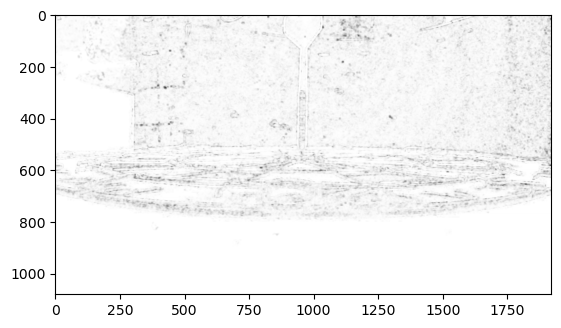

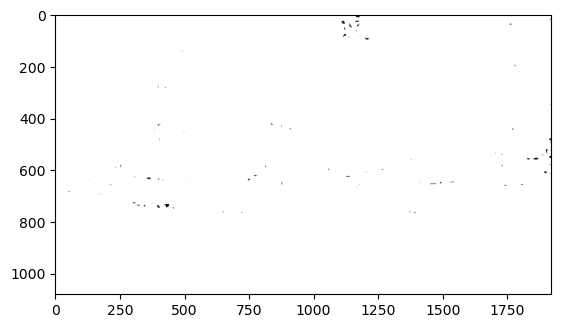

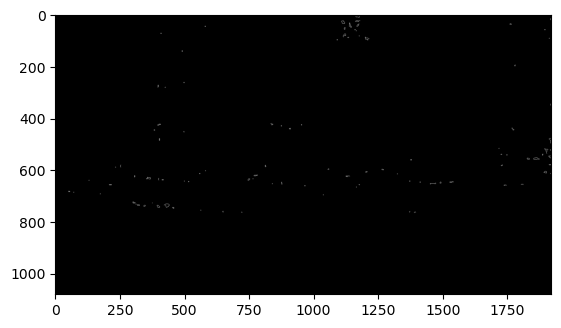

Image processing time: 1.3529551029205322
x-pixel_cor: 1853


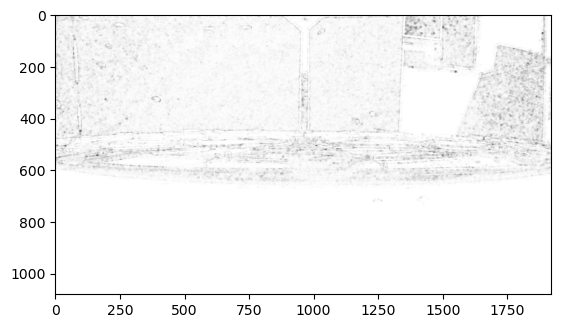

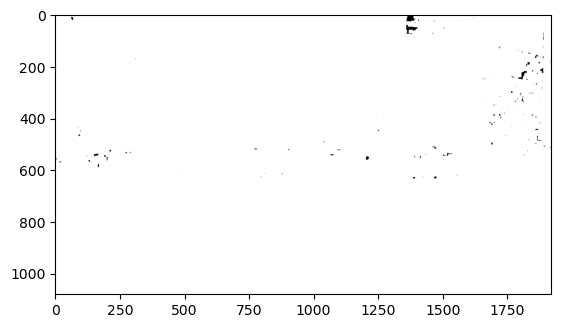

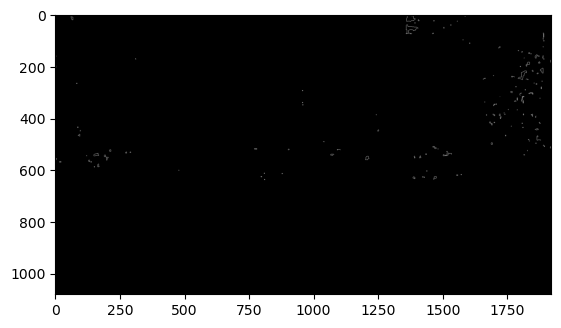

Image processing time: 1.3076190948486328
x-pixel_cor: 1809
image coordinates:  [1853, 1809]


TypeError: compute_angles() takes 1 positional argument but 3 were given

In [28]:
# get dart tip coordinates from images
image_coordinates = get_image_coordinates()
print("image coordinates: ", image_coordinates)


# calculate angles of dart to cameras
angles_to_dart = compute_angles(image_coordinates, fov, image_width)
print("angles to dart: ", angles_to_dart)

In [23]:
# Create Visualiation of Dart Board
fig, ax = plt.subplots() 
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
dart_board = plt.Circle((0, 0), board_radius, edgecolor='black', fill=False)
#dart_board = ax.pie([.05]*20)
dart = plt.Arrow(x_dart, y_dart, 15, 15, color='black')
bullseye = plt.Circle((0, 0), 10, edgecolor='black', fill=False)
camA = plt.Rectangle((x1, y1), 10, 10, edgecolor='black', fill=False, clip_on=False)
camB = plt.Rectangle((x2, y2), 10, 10, edgecolor='black', fill=False, clip_on=False) 
ax.add_patch(dart_board)
ax.add_patch(dart)
ax.add_patch(bullseye)
ax.add_patch(camA)
ax.add_patch(camB)
leg_Cam1_Dart = ax.axline((x1, y1), slope = camX.slope1)
leg_Cam2_Dart = ax.axline((x2, y2), slope = camX.slope2)
ax.plot(x_dart, y_dart)
plt.show()

option = input("1 to run program again, 0 to exit: ")


TypeError: get_image_coordinate() missing 1 required positional argument: 'imageB'